In [1]:
import scipy
import numpy as np
from scipy.special import roots_legendre, eval_legendre
from numpy.linalg import norm
# from scipy.optimize import minimize

## Stage 1: Construct an initial quadrature on X


In [2]:
## X is a Rectangle
a,b = -1,1
c,d = -1,1

n = 4
roots, weights = roots_legendre(n)
mapped_roots = a + (b-a)*(roots+1)/2
mapped_weights = (b-a)*weights/2
tensor_w = mapped_weights.reshape(n,1)@mapped_weights.reshape(1,n)

# Stage 2: Construct an orthonormal basis of the space $P_n$

In [3]:
def int_f(f,n):
    res = 0
    for i in range(n):
        for j in range(n):
            res += tensor_w[i][j] * f(mapped_roots[i] , mapped_roots[j])
    return res

def start(i,N):
    return (2*N+4-i)*(i-1) // 2
def end(i,N):
    return (2*N+3-i)*i//2-1

def vec2tri(vec,N):
    empty = np.zeros((N+1,N+1))
    for row in range(N):
        s = start(row+1,N)
        e = end(row+1,N)
        new_row = np.concatenate([vec[s:e+1],np.zeros(N-(e-s))],axis=0)
        empty[row] += new_row
    return empty

def tri2vec(tri,N):
    l = []
    for row in range(N+1):
         l.append(tri[row][:N+1-row])
    return np.block(l)

def xvec(vec,k,N):
    vec_tri = vec2tri(vec,N)
    newtri = np.zeros((N+1,N+1))
    for i in range(k):
        for j in range(k):
            if vec_tri[i,j] != 0:
                newtri[i+1,j] = vec_tri[i,j]
    return tri2vec(newtri,N)

def yvec(vec,k,N):
    vec_tri = vec2tri(vec,N)
    newtri = np.zeros((N+1,N+1))
    for i in range(k):
        for j in range(k):
            if vec_tri[i,j] != 0:
                newtri[i,j+1] = vec_tri[i,j]
    return tri2vec(newtri,N)

def eval_vec(vec,x,y,n):
    mat = vec2tri(vec,n)
    res = 0
    for row in range(n):
        for j in range(n):
            if mat[row][j] != 0:
                res += mat[row][j] * x**row * y**j
    return res

def eval_xderivative(vec,x,y,n):
    mat = vec2tri(vec,n)
    res = 0
    for row in range(n):
        for j in range(n):
            if mat[row][j] != 0:
                if row == 0:
                    res += 0
                else:
                    res += row * mat[row][j] * x**(row-1) * y**j
    return res

def eval_yderivative(vec,x,y,n):
    mat = vec2tri(vec,n)
    res = 0
    for row in range(n):
        for j in range(n):
            if mat[row][j] != 0:
                if j == 0:
                    res += 0
                else:
                    res += j * mat[row][j] * x**row * y**(j-1)
    return res

def find_basis(d):
    p0 = np.block([1,np.zeros((d+1)*(d+2)//2-1)])
    basis = [p0.reshape(-1,1)]

    for k in range(1,d+1):
        cb = basis.copy()
        for p in basis:
            xb = xvec(p.flatten(),k,d)
            yb = yvec(p.flatten(),k,d)
            cb.append(xb.reshape(-1,1))
            cb.append(yb.reshape(-1,1))
        threeK = np.concatenate(cb,axis=1)    
        u,r,vh = scipy.linalg.svd(threeK)
        basis = []
        for i in range(r.shape[0]):
            basis.append(u[:,i].reshape(-1,1))
    return basis

basis = find_basis(n)

# Stage 3: Find the eigenvalues of $P_U \circ M_{x+iy}$

In [4]:
N = len(basis)
A = np.zeros((N,N),dtype=complex)
for i in range(N):
    for j in range(N):
        f = lambda x,y: complex(x,y)*eval_vec(basis[i].flatten(),x,y,n)*np.conj(eval_vec(basis[j].flatten(),x,y,n))
        A[i][j] = int_f(f,n)
eigens = scipy.linalg.eigvals(A)
X,Y = eigens.real,eigens.imag

# Stage 4: Construct the quadrature

In [5]:
m = n
M =(m+1)*(m+2)//2
basis_m = find_basis(m)
I = []
for j in range(M):
    f = lambda x,y: eval_vec(basis_m[j].flatten(),x,y,m)
    I.append(int_f(f,n))


phi = np.zeros((M,eigens.shape[0]))
for i in range(M):
    p = basis_m[i].flatten()
    for j in range(mapped_roots.shape[0]):
        r = mapped_roots[j]
        phi[i][j] = eval_vec(p,r,r,m)
omega = np.linalg.pinv(phi)@np.array(I)

In [8]:
x0 = np.concatenate([X,Y,omega])
NN = (n+1)*(n+2)//2

def F(point):
    x = point[:NN]
    y = point[NN:2*NN]
    w = point[2*NN:]
    res = np.zeros(M)
    for i in range(M):
        eval = np.array([eval_vec(basis_m[i].flatten(),x[i],y[i],m) for i in range(NN)])
        res[i] = eval@w
    res -= I
    return res

def residual(point):
    return (F(point)**2).sum()

def J(point):
    x = point[:NN]
    y = point[NN:2*NN]
    w = point[2*NN:]

    res = np.zeros((M,3*NN))
    for i in range(M):
        dx = np.array([eval_xderivative(basis_m[i].flatten(),x[j],y[j],m) for j in range(NN)])*w
        dy = np.array([eval_yderivative(basis_m[i].flatten(),x[j],y[j],m) for j in range(NN)])*w
        dw = np.array([eval_vec(basis_m[i].flatten(),x[j],y[j],m) for j in range(NN)])
        res[i] = np.concatenate([dx,dy,dw],axis=0)
    return res

tol = 1e-8
point = x0
step = 0
for i in range(10):

    step += 1

    # mul = lambda x: J(point).T@(J(point)@x)
    # Jt_J = scipy.sparse.linalg.LinearOperator(
    #     shape=(3*NN, 3*NN), matvec=mul, rmatvec=mul, matmat=mul, rmatmat=mul)
    # point_proposal = point - scipy.sparse.linalg.cg(Jt_J, J(point).T@F(point), tol=min(tol, residual(point)))[0]
    point_proposal = point - scipy.linalg.pinv(J(point).T@J(point))@(J(point).T)@F(point)
    if residual(point_proposal) <= tol:
        point = point_proposal
        break
    # if step % 10 == 0:
    #     print('{}th residual is {}.'.format(step,residual(point)))
    point = point_proposal

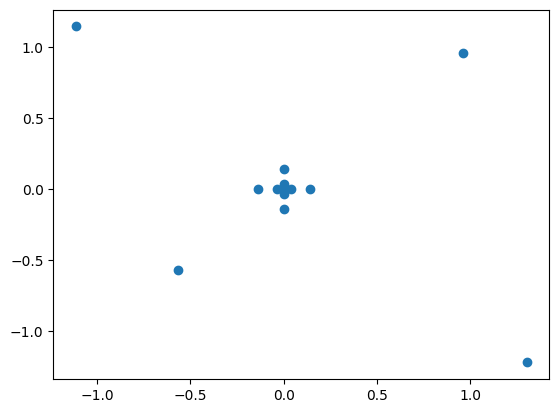

In [10]:
x = point[:NN]
y = point[NN:2*NN]
w = point[2*NN:]
import matplotlib.pyplot as plt
plt.scatter(x,y)